In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from ml_collections import config_dict
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from hierarqcal import Qcycle, Qmask, Qinit, Qunitary, Qmotif, Qpermute
from sklearn.metrics import f1_score


In [11]:
data_config = {
    "data_path": "C:/Users/Admin/Desktop/Quantum/Training and Testing Sets/UNSW_NB15_testing-set.csv",
    "split": 0.2,
    "num_pca_components": 7,
    "batch_size": 32,
    "num_workers": 4,

}

Samples = namedtuple("samples", ["x_train", "x_test", "y_train", "y_test"])

# Preprocessing pipelines
pipeline_ang = Pipeline([
    ("scaler", MinMaxScaler((0, 2 * np.pi))),  # Scale features for PCA
    ("pca", PCA(data_config["num_pca_components"])),
])

pipeline_amp = Pipeline([
    ("scaler", MinMaxScaler((0, 1))),          # Scale features for normalization
    #("normalizer", Normalizer(norm="l2")),     # Normalize for amplitude encoding
])

def get_raw_samples(cfg, state):
    """Load raw samples and preprocess them."""
    # Load data
    data = pd.read_csv(cfg["data_path"])
    
    # Encode non-numeric columns
    non_numeric_cols = data.select_dtypes(include=["object"]).columns
    print("Non-numeric columns:", non_numeric_cols)
    for col in non_numeric_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    
    # Define features and target
    target = "label"
    X = data.drop(columns=["attack_cat", "id", target]).to_numpy()
    y = data[target].to_numpy()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=1000, test_size=200, random_state=state, stratify=y
    )
    
    return Samples(X_train, X_test, y_train, y_test)

def preprocess_samples(samples, pipeline):
    """Apply preprocessing pipeline to samples."""
    X_train = pipeline.fit_transform(samples.x_train)
    X_test = pipeline.transform(samples.x_test)
    return Samples(X_train, X_test, samples.y_train, samples.y_test)

# Main processing
# Preprocessing step
samples_raw = get_raw_samples(data_config, 42)
samples_preprocessed = preprocess_samples(samples_raw, pipeline_ang)

# Unpack preprocessed data
X_train, X_test, y_train, y_test = (
    samples_preprocessed.x_train,
    samples_preprocessed.x_test,
    samples_preprocessed.y_train,
    samples_preprocessed.y_test,
)

# Convert to PyTorch tensors and create DataLoaders
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    ),
    batch_size=data_config["batch_size"],
    shuffle=True,
    num_workers=data_config["num_workers"]
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    ),
    batch_size=data_config["batch_size"],
    shuffle=False,
    num_workers=data_config["num_workers"]
)

# Summary
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


Non-numeric columns: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
Number of training batches: 32
Number of testing batches: 7


In [12]:
class QCNN(nn.Module):
    """QCNN for classification"""
    def __init__(self, qnode, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.loss_func = nn.NLLLoss()
        
    def forward(self, x):
        return self.qlayer(x)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)                 # Generate predictions
        loss = self.loss_func(logits, y)  # Calculate loss
        acc = accuracy(logits, y)         # Calculate accuracy
        f1 = compute_f1(logits, y)        # Calculate F1 score
        return loss, acc, f1

    def validation_step(self, batch):
        x, y = batch
        logits = self(x)                  # Generate predictions
        loss = self.loss_func(logits, y)  # Calculate loss
        acc = accuracy(logits, y)         # Calculate accuracy
        f1 = compute_f1(logits, y)        # Calculate F1 score
        return {'val_loss': loss, 'val_acc': acc, 'val_f1': f1}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        epoch_f1 = torch.tensor([x['val_f1'] for x in outputs]).mean()  # Combine F1 scores
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_f1': epoch_f1.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, train_f1: {result['train_f1']:.4f}")

# set up pennylane circuit
def get_circuit(hierq, embedding='AngleEmbedding', **kwargs):
    dev = qml.device("default.qubit", wires=hierq.tail.Q)

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        getattr(qml, embedding)(features=inputs, wires=hierq.tail.Q, **kwargs)
        hierq.set_symbols(weights)
        hierq(backend="pennylane")  # This executes the compute graph in order
        return qml.probs(wires=hierq.head.Q[0])


    return circuit

# Create Qcnn
def penny_gate_to_function(gate):
    return lambda bits, symbols: gate(*symbols, wires=[*bits])


def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1, keepdim=True)
    return torch.tensor(preds.eq(labels.view_as(preds)).sum().item() / len(labels))


def compute_f1(outputs, labels):
    preds = outputs.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, preds, average="weighted")
    
def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode
    outputs = []
    total_loss, total_acc, total_f1 = 0, 0, 0
    total_batches = len(loader)

    with torch.no_grad():
        for batch in loader:
            result = model.validation_step(batch)
            outputs.append(result)
            total_loss += result['val_loss'].item()
            total_acc += result['val_acc'].item()
            total_f1 += result['val_f1']

    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    avg_f1 = total_f1 / total_batches

    #print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_acc:.4f}, Validation F1: {avg_f1:.4f}")

    return model.validation_epoch_end(outputs)


def fit(cfg, model, train_loader, opt_func=torch.optim.SGD, **optimizer_kwargs):
    history = []
    optimizer = opt_func(model.parameters(), lr=cfg.learning_rate, **optimizer_kwargs)

    for epoch in range(cfg.num_epochs):
        # Training phase
        batch_losses, batch_accs, batch_f1s = [], [], []
        for batch in train_loader:
            loss, acc, f1 = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_losses.append(loss)
            batch_accs.append(acc)
            batch_f1s.append(f1)

        # Calculate epoch metrics
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean()
        epoch_f1 = torch.tensor(batch_f1s).mean()

        # Log results for the epoch
        history.append({'train_loss': epoch_loss.item(), 
                        'train_acc': epoch_acc.item(),
                        'train_f1': epoch_f1.item()})
        #model.epoch_end(epoch, history[-1])

    return history



In [13]:
def ansatz6(bits, symbols):
        # First layer of RX and RZ gates
    s = -1
    for i in range(len(bits)):
        
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    for x in range(len(bits)-1,-1,-1):
        for y in range(len(bits)-1,-1,-1):
            if x==y:
                pass
            else:
                qml.CRX(symbols[s], wires=[bits[x], bits[y]])
                s+=1
    s+=1
    for i in range(len(bits)):
        
        qml.RX(symbols[(2*i)+s], wires=bits[i])
        qml.RZ(symbols[(2*i)+1+s], wires=bits[i])
    

def ansatz5(bits, symbols):
        # First layer of RX and RZ gates

    s=-1
    for i in range(len(bits)):
        
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    
    for x in range(len(bits)-1,-1,-1):
        for y in range(len(bits)-1,-1,-1):
            if x==y:
                pass
            else:
                s+=1
                qml.CRZ(symbols[s], wires=[bits[x], bits[y]])            
    s+=1
    for i in range(len(bits)):
        
        qml.RX(symbols[(2*i)+s], wires=bits[i])
        qml.RZ(symbols[(2*i)+1+s], wires=bits[i])
    s += (2*len(bits))
    #print (s)
    
def ansatz14(bits, symbols):
        # First layer of RX and RZ gates
    s=0
    for i in range(len(bits)):
        qml.RY(symbols[i], wires=bits[i])
        s+=1
    for x in range(len(bits)-1,-1,-1):
        qml.CRX(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    for i in range(len(bits)):
        qml.RY(symbols[s], wires=bits[i])
        s+=1
    for x in range(0, len(bits)):
        qml.CRX(symbols[s], wires=[bits[(x+len(bits) )% len(bits)], bits[(x+len(bits) -1)% len(bits)]])
        s+=1

def ansatz13(bits, symbols):
        # First layer of RX and RZ gates

    s=0
    for i in range(len(bits)):
        qml.RY(symbols[i], wires=bits[i])
        s+=1
    for x in range(len(bits)-1,-1,-1):
        qml.CRZ(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    for i in range(len(bits)):
        qml.RY(symbols[s], wires=bits[i])
        s+=1
    for x in range(0, len(bits)):
        qml.CRZ(symbols[s], wires=[bits[(x+len(bits) )% len(bits)], bits[(x+len(bits) -1)% len(bits)]])
        s+=1
    #print (s)

def ansatz19(bits, symbols):
        # First layer of RX and RZ gates
    s=0
    for i in range(len(bits)):
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    for x in range(len(bits)-1,-1,-1):
        qml.CRX(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    #print(s)




In [14]:
def ansatz6_2(bits, symbols):

    s = -1
    for i in range(len(bits)):
        
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    for x in range(len(bits)-1,-1,-1):
        for y in range(len(bits)-1,-1,-1):
            if x==y:
                pass
            else:
                qml.CRX(symbols[s], wires=[bits[x], bits[y]])
                s+=1
    s+=1
    for i in range(len(bits)):
        
        qml.RX(symbols[(2*i)+s], wires=bits[i])
        qml.RZ(symbols[(2*i)+1+s], wires=bits[i])


def ansatz5_2(bits, symbols):
        # First layer of RX and RZ gates
    s=-1
    for i in range(len(bits)):
        
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    
    for x in range(len(bits)-1,-1,-1):
        for y in range(len(bits)-1,-1,-1):
            if x==y:
                pass
            else:
                s+=1
                qml.CRZ(symbols[s], wires=[bits[x], bits[y]])            
    s+=1
    for i in range(len(bits)):
        
        qml.RX(symbols[(2*i)+s], wires=bits[i])
        qml.RZ(symbols[(2*i)+1+s], wires=bits[i])
    s += (2*len(bits))
    #print (s)
    
def ansatz14_2(bits, symbols):
        # First layer of RX and RZ gates
    s=0
    for i in range(len(bits)):
        qml.RY(symbols[i], wires=bits[i])
        s+=1
    for x in range(len(bits)-1,-1,-1):
        qml.CRX(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    for i in range(len(bits)):
        qml.RY(symbols[s], wires=bits[i])
        s+=1
    for x in range(0, len(bits)):
        qml.CRX(symbols[s], wires=[bits[(x+len(bits) )% len(bits)], bits[(x+len(bits) -1)% len(bits)]])
        s+=1

def ansatz13_2(bits, symbols):
        # First layer of RX and RZ gates
    s=0
    for i in range(len(bits)):
        qml.RY(symbols[i], wires=bits[i])
        s+=1
    for x in range(len(bits)-1,-1,-1):
        qml.CRZ(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    for i in range(len(bits)):
        qml.RY(symbols[s], wires=bits[i])
        s+=1
    for x in range(0, len(bits)):
        qml.CRZ(symbols[s], wires=[bits[(x+len(bits) )% len(bits)], bits[(x+len(bits) -1)% len(bits)]])
        s+=1
    #print (s)

def ansatz19_2(bits, symbols):
        # First layer of RX and RZ gates
    s=0
    for i in range(len(bits)):
        qml.RX(symbols[2*i], wires=bits[i])
        qml.RZ(symbols[(2*i)+1], wires=bits[i])
        s+=2
    for x in range(len(bits)-1,-1,-1):
        qml.CRX(symbols[s], wires=[bits[x], bits[(x+1 )% len(bits)]])
        s+=1
    #print(s)



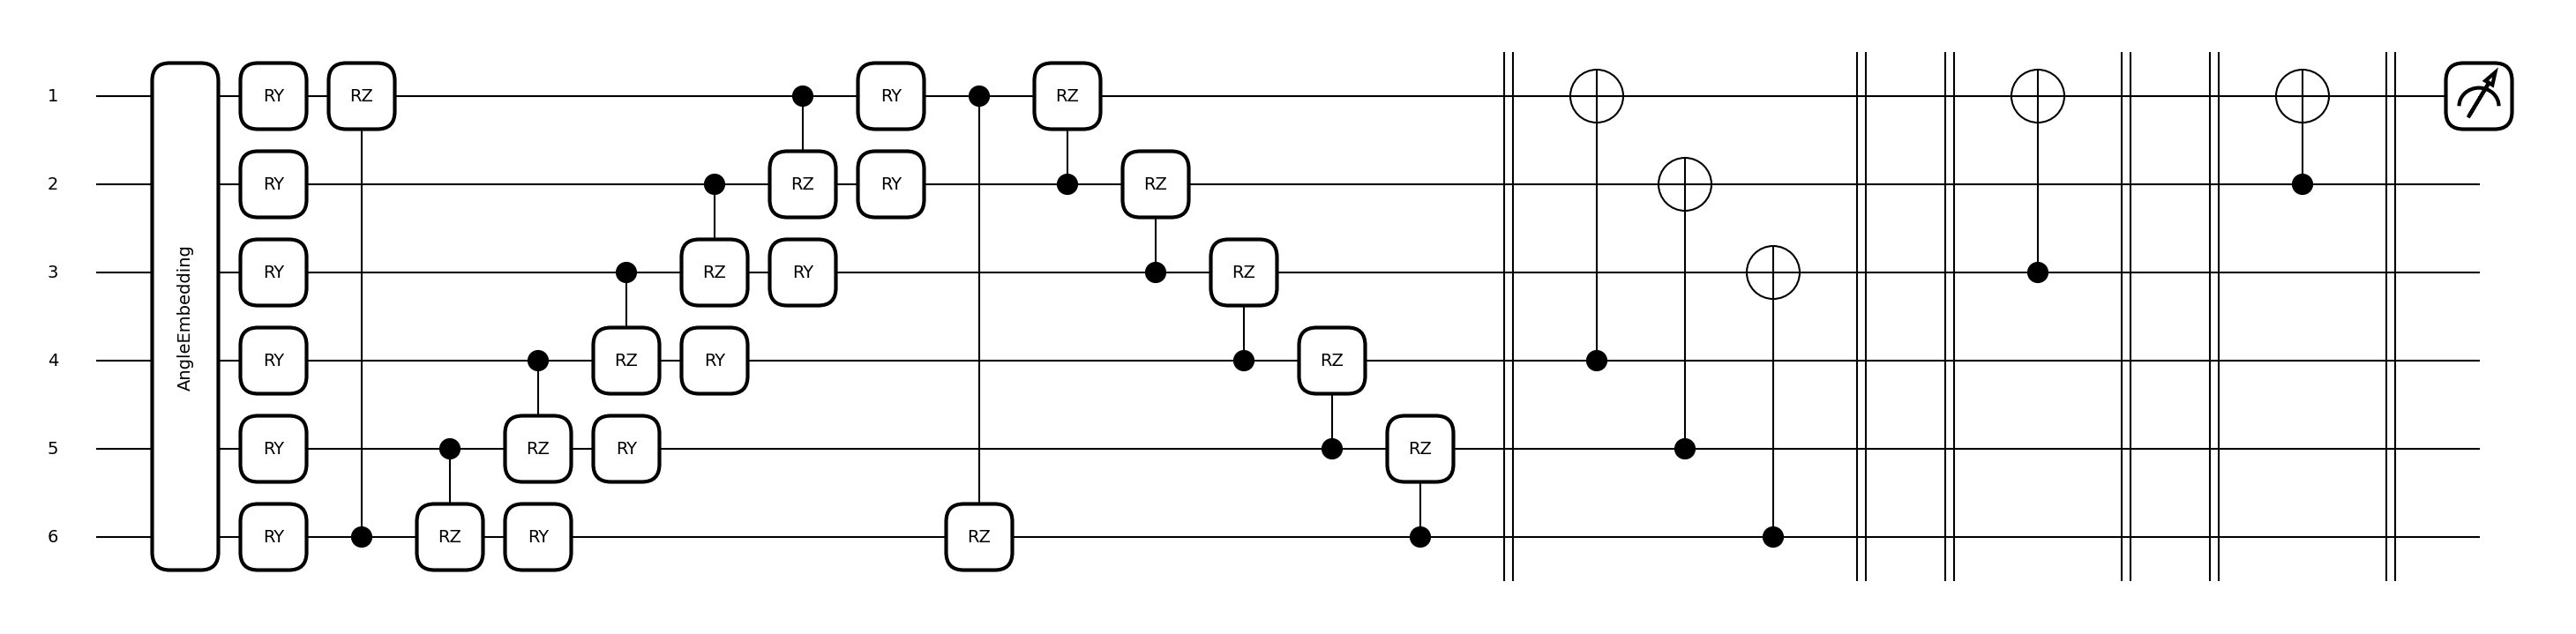

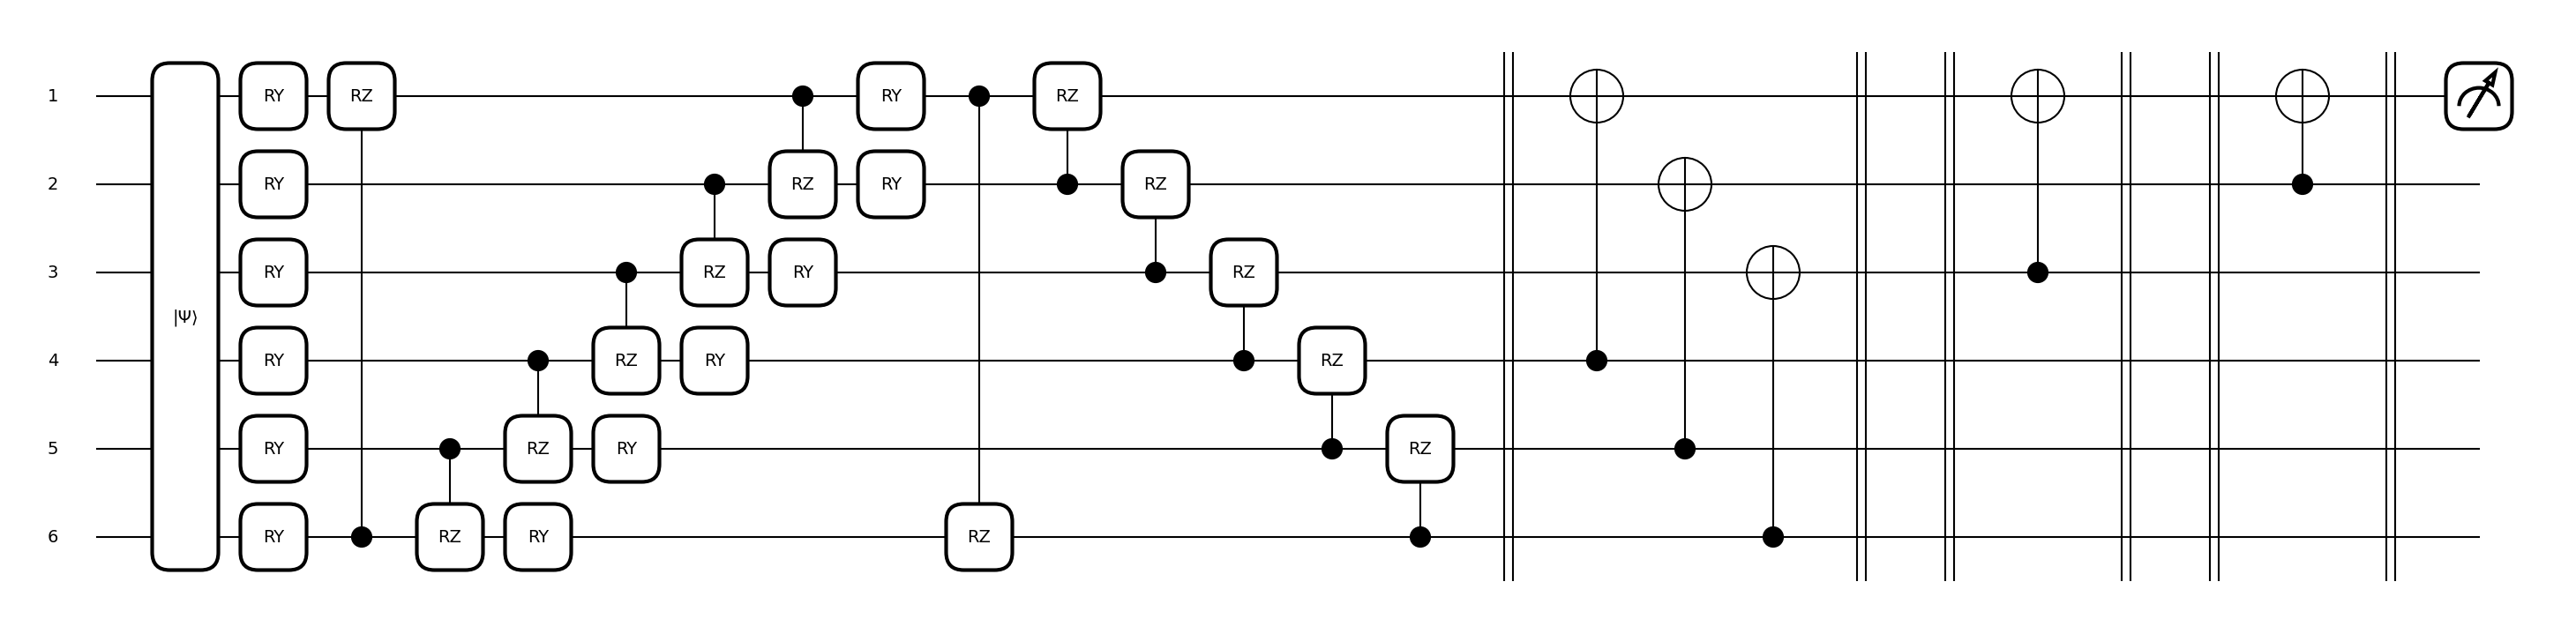

In [25]:
primitive_gates = ["CRZ", "CRX", "CRY", "RZ", "RX", "RY", "Hadamard", "CNOT", "PauliX"]
penny_gates = [getattr(qml, gate_name) for gate_name in primitive_gates]
hierq_gates = {
    primitive_gate: Qunitary(
        penny_gate_to_function(penny_gate),
        n_symbols=penny_gate.num_params,
        arity=penny_gate.num_wires,
    )
    for primitive_gate, penny_gate in zip(primitive_gates, penny_gates)
}

'''qcnn = (
    Qinit(6)
    + (
        Qcycle(
            stride = 1,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz19, n_symbols=100, arity=6),
            share_weights=False,

        )

        
        + Qmask("*!", mapping=hierq_gates["CNOT"])        

        +Qpermute(mapping=Qunitary(ansatz19_2, n_symbols=50, arity = 3), share_weights=False, # keep arity 4 for accurate layer mirrors 

        )
    ) *3
    
)'''

def make_QCNN(embedding, ansatz, layers = None, param_size = [100,50]):
    if embedding == "AngleEmbedding":
        qubit_size = [7,4]
    else:
        qubit_size = [6,3]
    if layers != None:
        qcnn = (
            Qinit(qubit_size[0])
            + (
                Qcycle(
                    stride = 1,
                    step=1,
                    offset=0,
                    mapping=Qunitary(ansatz, n_symbols=param_size[0], arity=qubit_size[0]),
                    share_weights=False,
                )
                + Qmask("*!", mapping=hierq_gates["CNOT"])        
                + Qpermute(mapping=Qunitary(layers, n_symbols=param_size[1], arity = qubit_size[1]), share_weights=False, 
                )
            ) *3
            
        )
    else: 
        qcnn = (
        Qinit(qubit_size[0])
        + (
            Qcycle(
                stride = 1,
                step=1,
                offset=0,
                mapping=Qunitary(ansatz, n_symbols=param_size[0], arity=qubit_size[0]),
                share_weights=False,
            )
            + Qmask("*!", mapping=hierq_gates["CNOT"])        
        ) *3
        
    )

    return qcnn


qcnn = make_QCNN("Amp",ansatz13)
# plot circuit
x, w = torch.rand(6), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, rotation='X'))(x, w)
x, w = torch.rand(64), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, 'AmplitudeEmbedding', pad_with = 0, normalize=True))(x, w)




In [7]:
weight_shapes = {"weights": qcnn.n_symbols}

# Configuration for the model
model_config = config_dict.ConfigDict()
model_config.learning_rate = 0.1
model_config.num_epochs = 25
model_config.optimizer = 'Adam'  # Choose optimizer (e.g., 'Adam', 'SGD')

# Additional optimizer-specific configurations
momentum_value = 0.9  # Momentum for SGD
weight_decay_value = 1e-4  # Weight decay for regularization

# Create the quantum circuit
circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)

# Initialize the QCNN model
model = QCNN(circuit, weight_shapes)

# Select the optimizer dynamically
optimizer_class = getattr(torch.optim, model_config.optimizer)

# Train the model with optimizer-specific arguments
if model_config.optimizer == 'SGD':
    history = fit(model_config, model, train_loader, optimizer_class, momentum=momentum_value, weight_decay=weight_decay_value)
elif model_config.optimizer == 'Adam':
    history = fit(model_config, model, train_loader, optimizer_class, weight_decay=weight_decay_value)
else:
    history = fit(model_config, model, train_loader, optimizer_class)

# Evaluate the model on the test set
test = evaluate(model, test_loader)

KeyboardInterrupt: 

In [8]:
import csv

def save_metrics_to_csv(filename, records):
    """
    Save training and validation metrics for different random states to a CSV file.

    Args:
        filename (str): Path to the CSV file to save metrics.
        records (list of dict): List of records, where each record contains training metrics
                                and configuration details.
    """
    if not records:
        print("No records to save.")
        return
    
    # Prepare the CSV header based on the keys of the first record
    header = records[0].keys()
    
    # Write to CSV
    with open(filename, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()
        writer.writerows(records)
    
    print(f"Metrics saved to {filename}")


In [ ]:
from ml_collections import config_dict

# Configuration
optomisers = ["SGD","Adam"]
learning_rates = [0.1, 0.05, 0.02, 0.01]
momentum_value = 0.3
weight_decay_value = 0
ansatz_functions = [ansatz5, ansatz6, ansatz13, ansatz14, ansatz19]
layer_functions = [ansatz5_2, ansatz6_2, ansatz13_2, ansatz14_2, ansatz19_2]
ansatz_name = ["ansatz5", "ansatz6", "ansatz13", "ansatz14", "ansatz19"]
param_ang = [[70,28], [70,28], [28,16], [28,16], [21,12]]
param_amp = [[54,18], [54,18], [24,12], [24,12], [18,9]]
random_states = [ 69, 77, 72, 38, 36, 55, 90, 98, 22, 57, 40, 80, 93, 75, 86]
embeddings = ["AngleEmbedding", "AmplitudeEmbedding"]
batch_size = 32
layers = [1,2]
epochs = [10, 20]
results = []  # List to store results for each random state
random_state =  40
#for random_state in random_states:
for embedding in embeddings:
    

    # Main processing
    # Preprocessing step
    samples_raw = get_raw_samples(data_config, random_state)
    if embedding == "AngleEmbedding":
        samples_preprocessed = preprocess_samples(samples_raw, pipeline_ang)
    elif embedding == "AmplitudeEmbedding":
        samples_preprocessed = preprocess_samples(samples_raw, pipeline_amp)

    # Unpack preprocessed data
    X_train, X_test, y_train, y_test = (
        samples_preprocessed.x_train,
        samples_preprocessed.x_test,
        samples_preprocessed.y_train,
        samples_preprocessed.y_test,
    )
    # Convert to PyTorch tensors and create DataLoaders
    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long)
        ),
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )

    test_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.long)
        ),
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )
    ansatz_count = -1
    for ansatz in ansatz_functions:
        ansatz_count +=1
        for layer in layers:
            if layer ==1:
                if embedding == "AngleEmbedding":
                    qcnn = make_QCNN(embedding,ansatz,param_size=param_ang[ansatz_count])
                    circuit = get_circuit(qcnn, rotation='X')
                elif embedding == "AmplitudeEmbedding":
                    qcnn = make_QCNN(embedding,ansatz,param_size=param_ang[ansatz_count])
                    circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)
            else: 
                if embedding == "AngleEmbedding":
                    qcnn = make_QCNN(embedding,ansatz,layers=layer_functions[ansatz_count],param_size=param_ang[ansatz_count])
                    circuit = get_circuit(qcnn, rotation='X')
                elif embedding == "AmplitudeEmbedding":
                    qcnn = make_QCNN(embedding,ansatz,layers=layer_functions[ansatz_count],param_size=param_ang[ansatz_count])
                    circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)
            
            # Define weight shapes for the quantum model
            weight_shapes = {"weights": qcnn.n_symbols}
            # Initialize the QCNN model
            model = QCNN(circuit, weight_shapes)


            for learning_rate in learning_rates:
                for opt in optomisers:
                    for epoch in epochs:
                        

            # Configuration for the model
                        model_config = config_dict.ConfigDict()
                        model_config.learning_rate = learning_rate
                        model_config.num_epochs = epoch
                        model_config.optimizer = opt 
                        

                        # Select the optimizer
                        optimizer_class = getattr(torch.optim, model_config.optimizer)

                        if model_config.optimizer == 'SGD':
                        

                            history = fit(model_config, model, train_loader, optimizer_class, momentum=momentum_value, weight_decay=weight_decay_value)
                            extra_info = {
                                'encoding': embedding,
                                'ansatz': ansatz_name[ansatz_count],
                                'layers': layer,
                                'random_state': random_state,
                                'batch_size': batch_size,
                                'decay': weight_decay_value,
                                'optimizer': model_config.optimizer,
                                'learning_rate': model_config.learning_rate,
                                'num_epochs': model_config.num_epochs,
                                'momentum': momentum_value
                            }
                        
                        elif model_config.optimizer == 'Adam':
                            history = fit(model_config, model, train_loader, optimizer_class, weight_decay=weight_decay_value)

                            extra_info = {
                                'encoding': embedding,
                                'ansatz': ansatz_name[ansatz_count],
                                'layers': layer,
                                'random_state': random_state,
                                'batch_size': batch_size,
                                'decay': weight_decay_value,
                                'optimizer': model_config.optimizer,
                                'learning_rate': model_config.learning_rate,
                                'num_epochs': model_config.num_epochs,
                                'momentum': 0
                            }

                        # Evaluate the model
                        
                        test_metrics = evaluate(model, test_loader)

                        record = {
                            'test_loss': test_metrics['val_loss'],
                            'test_acc': test_metrics['val_acc'],
                            'test_f1': test_metrics['val_f1'],
                            **extra_info
                        }
                        results.append(record)
        print(f"testing: "+ str(extra_info))

            
# Save all results to a CSV file
save_metrics_to_csv("experiment_results40.csv", results)



#random states, ansatzes, shots, batches, learning rates, optomisers+ momentum/decay 


Non-numeric columns: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'layers': 2, 'random_state': 40, 'batch_size': 32, 'decay': 0, 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 20, 'momentum': 0}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz6', 'layers': 2, 'random_state': 40, 'batch_size': 32, 'decay': 0, 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 20, 'momentum': 0}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz13', 'layers': 2, 'random_state': 40, 'batch_size': 32, 'decay': 0, 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 20, 'momentum': 0}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz14', 'layers': 2, 'random_state': 40, 'batch_size': 32, 'decay': 0, 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 20, 'momentum': 0}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz19', 'layers': 2, 'random_state': 40, 'batch_size

In [10]:
from ml_collections import config_dict

# Configuration
optomisers = ["SGD","Adam"]
learning_rates = [0.1, 0.05, 0.02, 0.01, 0.005, 0.001]
momentum = [0, 0.2, 0.3]
decay_rates = [0, 0.001, 0.01]
ansatz_functions = [ansatz5, ansatz6, ansatz13, ansatz14, ansatz19]
layer_functions = [ansatz5_2, ansatz6_2, ansatz13_2, ansatz14_2, ansatz19_2]
ansatz_name = ["ansatz5", "ansatz6", "ansatz13", "ansatz14", "ansatz19"]
param_ang = [[70,28], [70,28], [28,16], [28,16], [21,12]]
param_amp = [[54,18], [54,18], [24,12], [24,12], [18,9]]
random_states = [ 69, 77, 72, 38, 36, 55, 90, 98, 22, 57, 40, 80, 93, 75, 86]
shots = [1024, 8192, None]
embeddings = ["AngleEmbedding", "AmplitudeEmbedding"]
batch_sizes = [32,64]
layers = [1,2]
epochs = [5, 10, 20, 50]
results = []  # List to store results for each random state

def get_circuit(hierq, embedding='AngleEmbedding', **kwargs):
    dev = qml.device("default.qubit", wires=hierq.tail.Q)

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        getattr(qml, embedding)(features=inputs, wires=hierq.tail.Q, **kwargs)
        hierq.set_symbols(weights)
        hierq(backend="pennylane")  # This executes the compute graph in order

        return qml.probs(wires=hierq.head.Q[0])

    return circuit


for batch_size in batch_sizes:
    for embedding in embeddings:
        for random_state in random_states:

            # Main processing
            # Preprocessing step
            samples_raw = get_raw_samples(data_config, random_state)
            if embedding == "AngleEmbedding":
                samples_preprocessed = preprocess_samples(samples_raw, pipeline_ang)
            elif embedding == "AmplitudeEmbedding":
                samples_preprocessed = preprocess_samples(samples_raw, pipeline_amp)

            # Unpack preprocessed data
            X_train, X_test, y_train, y_test = (
                samples_preprocessed.x_train,
                samples_preprocessed.x_test,
                samples_preprocessed.y_train,
                samples_preprocessed.y_test,
            )
            # Convert to PyTorch tensors and create DataLoaders
            train_loader = DataLoader(
                TensorDataset(
                    torch.tensor(X_train, dtype=torch.float32),
                    torch.tensor(y_train, dtype=torch.long)
                ),
                batch_size=batch_size,
                shuffle=True,
                num_workers=4
            )

            test_loader = DataLoader(
                TensorDataset(
                    torch.tensor(X_test, dtype=torch.float32),
                    torch.tensor(y_test, dtype=torch.long)
                ),
                batch_size=batch_size,
                shuffle=False,
                num_workers=4
            )
            ansatz_count = -1
            for ansatz in ansatz_functions:
                ansatz_count +=1
                for layer in layers:
                    if layer ==1:
                        if embedding == "AngleEmbedding":
                            qcnn = make_QCNN(embedding,ansatz,param_size=param_ang[ansatz_count])
                            circuit = get_circuit(qcnn, rotation='X')
                        elif embedding == "AmplitudeEmbedding":
                            qcnn = make_QCNN(embedding,ansatz,param_size=param_ang[ansatz_count])
                            circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)
                    else: 
                        if embedding == "AngleEmbedding":
                            qcnn = make_QCNN(embedding,ansatz,layers=layer_functions[ansatz_count],param_size=param_ang[ansatz_count])
                            circuit = get_circuit(qcnn, rotation='X')
                        elif embedding == "AmplitudeEmbedding":
                            qcnn = make_QCNN(embedding,ansatz,layers=layer_functions[ansatz_count],param_size=param_ang[ansatz_count])
                            circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)
                    
                    # Define weight shapes for the quantum model
                    weight_shapes = {"weights": qcnn.n_symbols}
                    # Initialize the QCNN model
                    model = QCNN(circuit, weight_shapes)


                    for learning_rate in learning_rates:
                        for opt in optomisers:
                            for epoch in epochs:
                                for weight_decay_value in decay_rates:

                        # Configuration for the model
                                    model_config = config_dict.ConfigDict()
                                    model_config.learning_rate = learning_rate
                                    model_config.num_epochs = epoch
                                    model_config.optimizer = opt 
                                    

                                    # Select the optimizer
                                    optimizer_class = getattr(torch.optim, model_config.optimizer)

                                    if model_config.optimizer == 'SGD':
                                        for momentum_value in momentum:

                                            history = fit(model_config, model, train_loader, optimizer_class, momentum=momentum_value, weight_decay=weight_decay_value)
                                            extra_info = {
                                                'encoding': embedding,
                                                'ansatz': ansatz_name[ansatz_count],
                                                'random_state': random_state,
                                                'batch_size': batch_size,
                                                'decay': weight_decay_value,
                                                'optimizer': model_config.optimizer,
                                                'learning_rate': model_config.learning_rate,
                                                'num_epochs': model_config.num_epochs,
                                                'momentum': momentum_value
                                            }
                                    
                                    elif model_config.optimizer == 'Adam':
                                        history = fit(model_config, model, train_loader, optimizer_class, weight_decay=weight_decay_value)

                                        extra_info = {
                                            'encoding': embedding,
                                            'ansatz': ansatz_name[ansatz_count],
                                            'random_state': random_state,
                                            'batch_size': batch_size,
                                            'decay': weight_decay_value,
                                            'optimizer': model_config.optimizer,
                                            'learning_rate': model_config.learning_rate,
                                            'num_epochs': model_config.num_epochs,
                                            'momentum': 0
                                        }

                                    # Evaluate the model
                                    print(f"testing: "+ str(extra_info))
                                    test_metrics = evaluate(model, test_loader)

                                    # Combine results for each epoch with extra_info
                                    for epoch, metrics in enumerate(history, start=1):
                                        record = {
                                            'epoch': epoch,
                                            'train_loss': metrics['train_loss'],
                                            'train_acc': metrics['train_acc'],
                                            'train_f1': metrics['train_f1'],
                                            'test_loss': test_metrics['val_loss'],
                                            'test_acc': test_metrics['val_acc'],
                                            'test_f1': test_metrics['val_f1'],
                                            **extra_info
                                        }
                                        results.append(record)

            
# Save all results to a CSV file
save_metrics_to_csv("experiment_results.csv", results)



#random states, ansatzes, shots, batches, learning rates, optomisers+ momentum/decay 


Non-numeric columns: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'random_state': 69, 'batch_size': 32, 'decay': 0, 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5, 'momentum': 0.3}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'random_state': 69, 'batch_size': 32, 'decay': 0.001, 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5, 'momentum': 0.3}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'random_state': 69, 'batch_size': 32, 'decay': 0.01, 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5, 'momentum': 0.3}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'random_state': 69, 'batch_size': 32, 'decay': 0, 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 10, 'momentum': 0.3}
testing: {'encoding': 'AngleEmbedding', 'ansatz': 'ansatz5', 'random_state': 69, 'batch_size': 32, 'decay': 0.001, 'optimizer': 'SGD', 'learning_rate': 0.1,

KeyboardInterrupt: 

In [ ]:
weight_shapes = {"weights": qcnn.n_symbols}
model_config = config_dict.ConfigDict()
model_config.learning_rate = 0.1
model_config.num_epochs = 25

model_config.optimizer = 'Adam'

circuit = get_circuit(qcnn, 'AmplitudeEmbedding', pad_with=0.0, normalize=True)
model = QCNN(circuit, weight_shapes)
optimizer = getattr(torch.optim, model_config.optimizer)
history = fit(model_config, model, train_loader, optimizer) 
test = evaluate(model, test_loader)


Epoch [0], train_loss: -0.5589, train_acc: 0.7025
Epoch [1], train_loss: -0.5889, train_acc: 0.6900
Epoch [2], train_loss: -0.6043, train_acc: 0.6450
Epoch [3], train_loss: -0.6111, train_acc: 0.6925
Epoch [4], train_loss: -0.6139, train_acc: 0.6888
Epoch [5], train_loss: -0.6161, train_acc: 0.7063
Epoch [6], train_loss: -0.6198, train_acc: 0.6825
Epoch [7], train_loss: -0.6222, train_acc: 0.7150


KeyboardInterrupt: 

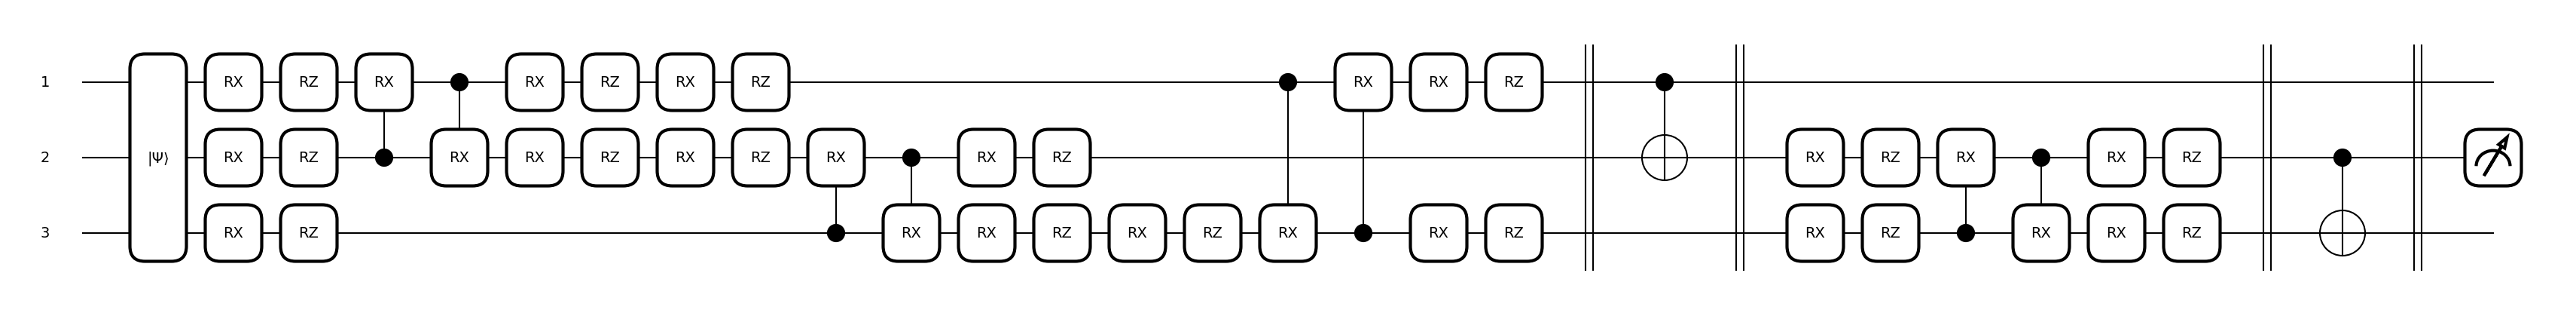

In [ ]:
qcnn = (
    Qinit(3)
    + (
        Qcycle(
            stride=1,
            step=1,
            offset=0,
            mapping=Qunitary(ansatz6, n_symbols=100, arity=2),
            share_weights=False,
        )
        + Qmask("!*", mapping=hierq_gates["CNOT"])
    )
    * 2
)

# plot circuit
x, w = torch.rand(8), torch.rand(qcnn.n_symbols)
fig, ax = qml.draw_mpl(get_circuit(qcnn, 'AmplitudeEmbedding', normalize=True))(x, w)

In [ ]:
weight_shapes = {"weights": qcnn.n_symbols}
model_config = config_dict.ConfigDict()
model_config.learning_rate = 0.1
model_config.num_epochs = 5
model_config.optimizer = 'Adam'

circuit = get_circuit(qcnn)
model = QCNN(circuit, weight_shapes)
optimizer = getattr(torch.optim, model_config.optimizer)

In [ ]:
history = fit(model_config, model, train_loader, optimizer)

ValueError: Features must be of length 3 or less; got length 42.